In [2]:
# check if a GPU is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

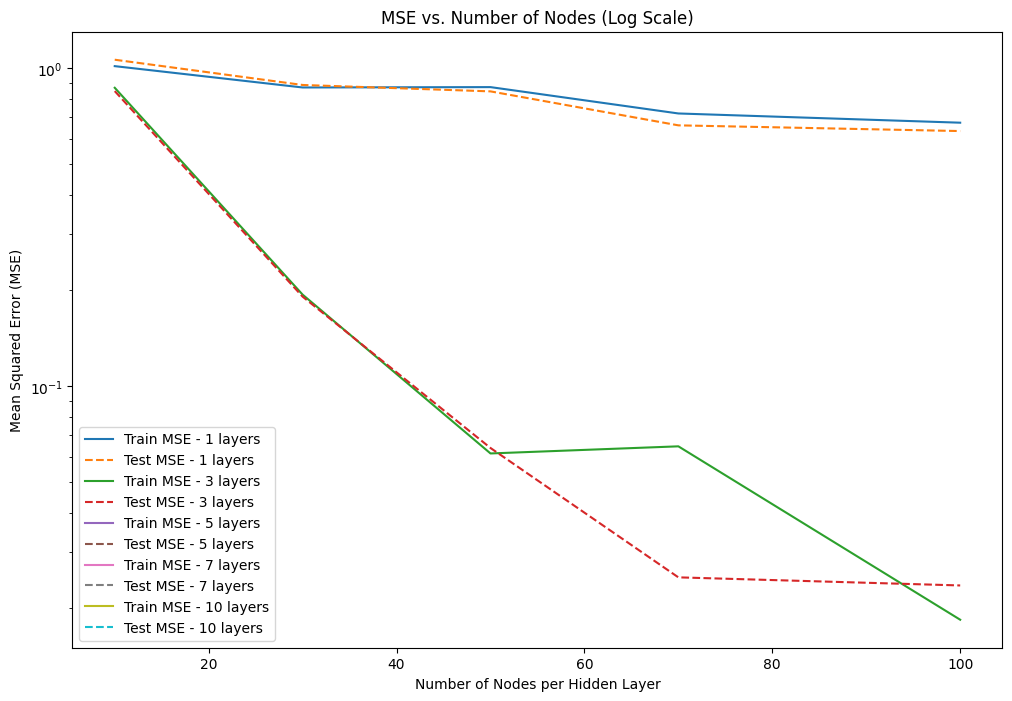

Train MSE: 0.0147, Test MSE: 0.0198
R2 score (Test): 0.9937
MAE (Train): 0.0912, MAE (Test): 0.1183


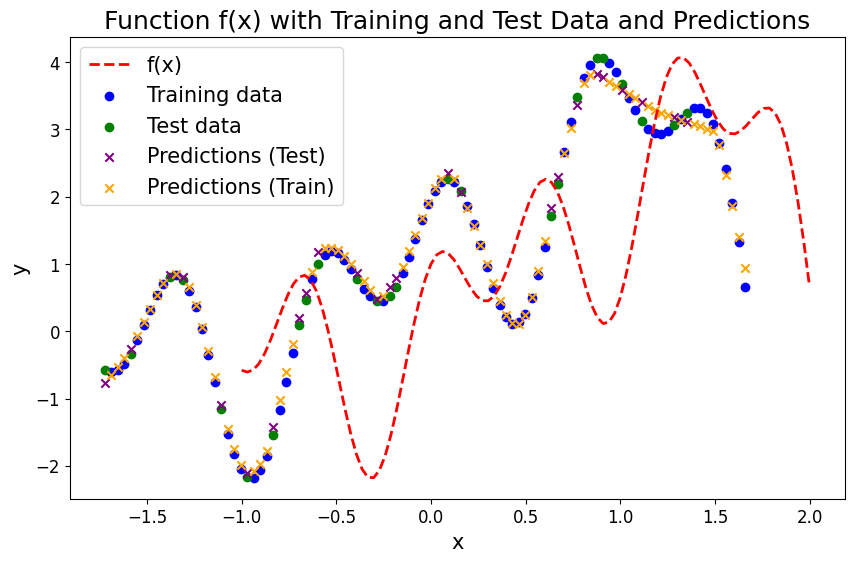

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import r2_score, mean_squared_error, mean_absolute_error

# Define the function f(x)
def f(x):
    return x + 1.5 * x**2 + 0.5 * x**3 - 0.7 * x**4 + np.sin(5 * x) + np.cos(10 * x)

# Generate and split data
x = np.linspace(-1, 2, 100).reshape(-1, 1)
y = f(x)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, random_state=42)

# Normalize the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

class Data(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray, device: str = 'cpu'):
        self.x = torch.from_numpy(x).float().to(device)
        self.y = torch.from_numpy(y).float().to(device)
        self.len = self.x.shape[0]
    
    def __getitem__(self, index: int) -> tuple:
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len

class MLP(nn.Module):
    def __init__(self, n_units: list, activation=nn.ReLU()):
        super().__init__()
        dims_in = n_units[:-1]
        dims_out = n_units[1:]
        layers = []
        for i, (dim_in, dim_out) in enumerate(zip(dims_in, dims_out)):
            layers.append(nn.Linear(dim_in, dim_out))
            if i < len(n_units) - 2:
                layers.append(activation)
        self._layers = nn.Sequential(*layers)

    def forward(self, x):
        return self._layers(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

def train(model: nn.Module, train_loader: DataLoader, optimizer: torch.optim.Optimizer, criterion: nn.modules.loss._Loss):
    model.train()
    epoch_loss = 0
    n_batches = len(train_loader)
    for data, target in train_loader:
        data = data.to(DEVICE)
        target = target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.data.item()
    return epoch_loss / n_batches

def evaluate(model: nn.Module, data_loader: DataLoader, criterion: nn.modules.loss._Loss):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(DEVICE)
            target = target.to(DEVICE)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.data.item()
    return total_loss / len(data_loader) #returns avg loss per batch

# Train the model
results = []
criterion = nn.MSELoss()
hidden_layers_range = [1, 3, 5, 7, 10]  # Select specific ranges for hidden layers
nodes_range = [10, 30, 50, 70, 100]     # Select specific ranges for nodes per layer

# Loop to train a maximum of 10 different models
for num_layers in hidden_layers_range:
    for num_nodes in nodes_range:
        if len(results) >= 10:
            break
        n_units = [1] + [num_nodes] * num_layers + [1]
        model = MLP(n_units).to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=0.0005)
        
        # Evaluate the final model
        train_data = Data(x_train, y_train, device=DEVICE)
        test_data = Data(x_test, y_test, device=DEVICE)
        
        train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

        # Train the final model
        n_epochs = 500  # Adjust epochs as necessary
        for epoch in range(n_epochs):
            train(model, train_loader, optimizer, criterion)

        train_mse = evaluate(model, train_loader, criterion)
        test_mse = evaluate(model, test_loader, criterion)
        results.append((num_layers, num_nodes, train_mse, test_mse))

# Plotting MSE results for test and train data
# Log scale on MSE values vs number of nodes
df = pd.DataFrame(results, columns=["hidden_layers", "nodes", "train_mse", "test_mse"])
plt.figure(figsize=(12, 8))

for hidden_layers in hidden_layers_range:
    subset = df[df["hidden_layers"] == hidden_layers]
    plt.plot(subset["nodes"], subset["train_mse"], label=f"Train MSE - {hidden_layers} layers")
    plt.plot(subset["nodes"], subset["test_mse"], label=f"Test MSE - {hidden_layers} layers", linestyle='--')

plt.yscale('log')
plt.xlabel("Number of Nodes per Hidden Layer")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs. Number of Nodes (Log Scale)")
plt.legend()
plt.show()

# Optimal model with low MSE
best_model_params = df.sort_values(by="test_mse").iloc[0]
hidden_layers = int(best_model_params["hidden_layers"])
nodes = int(best_model_params["nodes"])

# Create the final model
n_units = [1] + [nodes] * hidden_layers + [1]
final_model = MLP(n_units).to(DEVICE)
optimizer = optim.Adam(final_model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

# Train the final model
n_epochs = 700  # Adjust epochs as necessary
for epoch in range(n_epochs):
    train(final_model, train_loader, optimizer, criterion)

# Evaluate the final model
train_mse = evaluate(final_model, train_loader, criterion)
test_mse = evaluate(final_model, test_loader, criterion)

# Compute MAE, R^2 values for the model
final_model.eval()
with torch.no_grad():
    y_pred_test = final_model(torch.from_numpy(x_test).float().to(DEVICE))
    y_pred_train = final_model(torch.from_numpy(x_train).float().to(DEVICE))

r2_test = r2_score(y_pred_test.cpu(), torch.from_numpy(y_test).float().cpu())
mae_test = mean_absolute_error(y_pred_test.cpu(), torch.from_numpy(y_test).float().cpu())
mae_train = mean_absolute_error(y_pred_train.cpu(), torch.from_numpy(y_train).float().cpu())

# Print values
print(f'Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
print(f'R2 score (Test): {r2_test:.4f}')
print(f'MAE (Train): {mae_train:.4f}, MAE (Test): {mae_test:.4f}')

# Plot the functions and predictions
plt.figure(figsize=(10, 6))

# Plot the function f(x)
plt.plot(x, y, label='f(x)', color='red', linestyle='--', linewidth=2)

# Plot the training data
plt.scatter(x_train, y_train, label='Training data', color='blue')

# Plot the test data
plt.scatter(x_test, y_test, label='Test data', color='green')

# Plot the predictions
plt.scatter(x_test, y_pred_test.cpu(), label='Predictions (Test)', color='purple', marker='x')
plt.scatter(x_train, y_pred_train.cpu(), label='Predictions (Train)', color='orange', marker='x')

plt.legend(fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Function f(x) with Training and Test Data and Predictions', fontsize=18)
plt.show()